In [1]:
datapath = "../input/fetal-health-classification/"

from time import time
nb_start_time = time()

# Library Imnports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import DataLoader as DL
from torch.utils.data import Dataset
from torch.nn.utils import weight_norm as WN
import torch.nn.functional as F

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler

import random as r

# Helper Functions

In [3]:
def breaker():
    print("\n" + 30*"-" + "\n")

def head(x, no_of_ele=5):
    breaker()
    print(x[:no_of_ele])
    breaker()
    
def getCol(x):
    return [col for col in x.columns]

def getObj(x):
    s = (x.dtypes == "object")
    return list(s[s].index)

sc_X = StandardScaler()

# Data Handling

In [4]:
dataset = pd.read_csv(datapath + "fetal_health.csv")

breaker()
print("Dataset Shape :", repr(dataset.shape))
breaker()
print("Columns Names :\n")
cols = getCol(dataset)

for names in cols:
    print(names)
breaker()


------------------------------

Dataset Shape : (2126, 22)

------------------------------

Columns Names :

baseline value
accelerations
fetal_movement
uterine_contractions
light_decelerations
severe_decelerations
prolongued_decelerations
abnormal_short_term_variability
mean_value_of_short_term_variability
percentage_of_time_with_abnormal_long_term_variability
mean_value_of_long_term_variability
histogram_width
histogram_min
histogram_max
histogram_number_of_peaks
histogram_number_of_zeroes
histogram_mode
histogram_mean
histogram_median
histogram_variance
histogram_tendency
fetal_health

------------------------------



In [5]:
dataset.head(5)

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


**Setting up Independent and Dependent Variables**

In [6]:
y = dataset["fetal_health"].copy().values
X = dataset.iloc[:, :-1].copy().values

y = np.subtract(y, 1)
y = y.astype(int)

#X = sc_X.fit_transform(X)

num_features = X.shape[1]
del dataset

**Dataset Template**

In [7]:
class DS(Dataset):
    def __init__(this, X=None, y=None, mode="train"):
        this.mode = mode
        this.X = X
        if mode == "train":
            this.y = y
            
    def __len__(this):
        return this.X.shape[0]
    
    def __getitem__(this, idx):
        if this.mode == "train":
            return torch.FloatTensor(this.X[idx]), torch.LongTensor(this.y[idx])
        else:
            return torch.FloatTensor(this.X[idx])

# ANN

**Config**

In [8]:
class CFG():
    tr_batch_size = 64
    ts_batch_size = 64
    va_batch_size = 64
    
    epochs = 100
    n_folds = 5
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    IL   = num_features
    HL_1 = [128]
    HL_2 = [256, 128]
    HL_3 = [256, 128, 64]
    OL   = 3

cfg = CFG()

ts_data_setup = DS(X, None, "test")
ts_data = DL(ts_data_setup, batch_size=cfg.ts_batch_size, shuffle=False)

**Setup**

In [9]:
class ANN(nn.Module):
    def __init__(this, IL=None, HL=None, OL=None):
        super(ANN, this).__init__()
        
        this.HL = HL
        this.DP1 = nn.Dropout(p=0.2)
        this.DP2 = nn.Dropout(p=0.5)
        
        if len(HL) == 1:
            this.BN1 = nn.BatchNorm1d(IL)
            this.FC1 = WN(nn.Linear(IL, HL[0]))
            
            this.BN2 = nn.BatchNorm1d(HL[0])
            this.FC2 = WN(nn.Linear(HL[0], OL))
            
        elif len(HL) == 2:
            this.BN1 = nn.BatchNorm1d(IL)
            this.FC1 = WN(nn.Linear(IL, HL[0]))
            
            this.BN2 = nn.BatchNorm1d(HL[0])
            this.FC2 = WN(nn.Linear(HL[0], HL[1]))
            
            this.BN3 = nn.BatchNorm1d(HL[1])
            this.FC3 = WN(nn.Linear(HL[1], OL))
            
        elif len(HL) == 3:
            this.BN1 = nn.BatchNorm1d(IL)
            this.FC1 = WN(nn.Linear(IL, HL[0]))
            
            this.BN2 = nn.BatchNorm1d(HL[0])
            this.FC2 = WN(nn.Linear(HL[0], HL[1]))
            
            this.BN3 = nn.BatchNorm1d(HL[1])
            this.FC3 = WN(nn.Linear(HL[1], HL[2]))
            
            this.BN4 = nn.BatchNorm1d(HL[2])
            this.FC4 = WN(nn.Linear(HL[2], OL))
        
        else:
            raise NotImplementedError("Only Supports Networks of Depth 1, 2 and 3")
            
    def getOptimizer(this, A_or_S=0, lr=1e-3, wd=0):
        if A_or_S == 0:
            return optim.Adam(this.parameters(), lr=lr, weight_decay=wd)
        else:
            return optim.SGD(this.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
        
    def forward(this, x):
        if len(this.HL) == 1:
            x = this.BN1(x)
            #x = this.DP1(x)
            x = F.relu(this.FC1(x))
            x = this.BN2(x)
            #x = this.DP2(x)
            x = F.log_softmax(this.FC2(x), dim=1)
        elif len(this.HL) == 2:
            x = this.BN1(x)
            #x = this.DP1(x)
            x = F.relu(this.FC1(x))
            x = this.BN2(x)
            #x = this.DP2(x)
            x = F.relu(this.FC2(x))
            x = this.BN3(x)
            #x = this.DP2(x)
            x = F.log_softmax(this.FC3(x), dim=1)
        else:
            x = this.BN1(x)
            #x = this.DP1(x)
            x = F.relu(this.FC1(x))
            x = this.BN2(x)
            #x = this.DP2(x)
            x = F.relu(this.FC2(x))
            x = this.BN3(x)
            #x = this.DP2(x)
            x = F.relu(this.FC3(x))
            x = this.BN4(x)
            #x = this.DP2(x)
            x = F.log_softmax(this.FC4(x), dim=1)
        return x

**ANN Helpers**

In [10]:
def train_fn(X=None, y=None, n_folds=None, HL_Used=None):
    breaker()
    print("Training ...")
    breaker()
    
    LP = []
    names = []
    bestLoss = {"train" : np.inf, "valid" : np.inf}
    fold = 0
    
    start_time = time()
    for tr_idx, va_idx in StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=0).split(X, y):
        print("Processing Fold {fold} ...".format(fold=fold+1))
        
        X_train, X_valid, y_train, y_valid = X[tr_idx], X[va_idx], y[tr_idx], y[va_idx]
        
        tr_data_setup = DS(X_train, y_train.reshape(-1,1))
        va_data_setup = DS(X_valid, y_valid.reshape(-1,1))
        
        dataloaders = {"train" : DL(tr_data_setup, batch_size=cfg.tr_batch_size, shuffle=True, generator=torch.manual_seed(0)),
                       "valid" : DL(va_data_setup, batch_size=cfg.va_batch_size, shuffle=False)
                      }
        
        torch.manual_seed(0)
        model = ANN(cfg.IL, HL_Used, cfg.OL)
        model.to(cfg.device)
        
        optimizer = model.getOptimizer(A_or_S=1, lr=1e-3, wd=0)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, eps=1e-6, verbose=True)
        
        for e in range(cfg.epochs):
            epochLoss = {"train" : 0, "valid" : 0}
            for phase in ["train", "valid"]:
                if phase == "train":
                    model.train()
                else:
                    model.eval()
                lossPerPass = 0
                
                for feat, label in dataloaders[phase]:
                    feat, label = feat.to(cfg.device), label.to(cfg.device).view(-1)
                    
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == "train"):
                        output = model(feat)
                        loss   = nn.NLLLoss()(output, label)
                        if phase == "train":
                            loss.backward()
                            optimizer.step()
                    lossPerPass += (loss.item() / label.shape[0])
                epochLoss[phase] = lossPerPass
            LP.append(epochLoss)
            scheduler.step(epochLoss["valid"])
            if epochLoss["valid"] < bestLoss["valid"]:
                bestLoss = epochLoss
                name = "./Model_{id}_Fold_{fold}".format(id=len(HL_Used), fold=fold)
                names.append(name)
                torch.save(model.state_dict(), name)
        fold += 1
    
    breaker()
    print("Time Taken to Train {f} folds for {e} epochs : {:.2f} minutes".format((time() - start_time)/60, f=n_folds, e=cfg.epochs))
    breaker()
    print("Best Loss :", repr(bestLoss))
    breaker()

    return LP, names, model

def eval_fn(model=None, names=None, dataloader=None, num_obs_test=None):
    y_pred = np.zeros((num_obs_test, 1))
    
    for name in names:
        Preds = torch.zeros(cfg.ts_batch_size, 1).to(cfg.device)
        
        model.load_state_dict(torch.load(name))
        model.eval()
        
        for X in dataloader:
            X = X.to(cfg.device)
            with torch.no_grad():
                logProb = model(X)
            Prob = torch.exp(logProb)
            Pred = torch.argmax(Prob, dim=1)
            Preds = torch.cat((Preds, Pred.view(-1,1)), dim=0)
        Preds = Preds[cfg.ts_batch_size:].cpu().numpy()
        y_pred = np.add(y_pred, Preds)
    y_pred = np.divide(y_pred, len(names))
    return y_pred.astype(int)

# Configuration 1


------------------------------

Training ...

------------------------------

Processing Fold 1 ...
Epoch    35: reducing learning rate of group 0 to 1.0000e-04.
Epoch    46: reducing learning rate of group 0 to 1.0000e-05.
Epoch    50: reducing learning rate of group 0 to 1.0000e-06.
Processing Fold 2 ...
Epoch    69: reducing learning rate of group 0 to 1.0000e-04.
Epoch    76: reducing learning rate of group 0 to 1.0000e-05.
Epoch    80: reducing learning rate of group 0 to 1.0000e-06.
Processing Fold 3 ...
Epoch    49: reducing learning rate of group 0 to 1.0000e-04.
Epoch    55: reducing learning rate of group 0 to 1.0000e-05.
Epoch    59: reducing learning rate of group 0 to 1.0000e-06.
Processing Fold 4 ...
Processing Fold 5 ...
Epoch    55: reducing learning rate of group 0 to 1.0000e-04.
Epoch    59: reducing learning rate of group 0 to 1.0000e-05.
Epoch    65: reducing learning rate of group 0 to 1.0000e-06.

------------------------------

Time Taken to Train 5 folds for 10

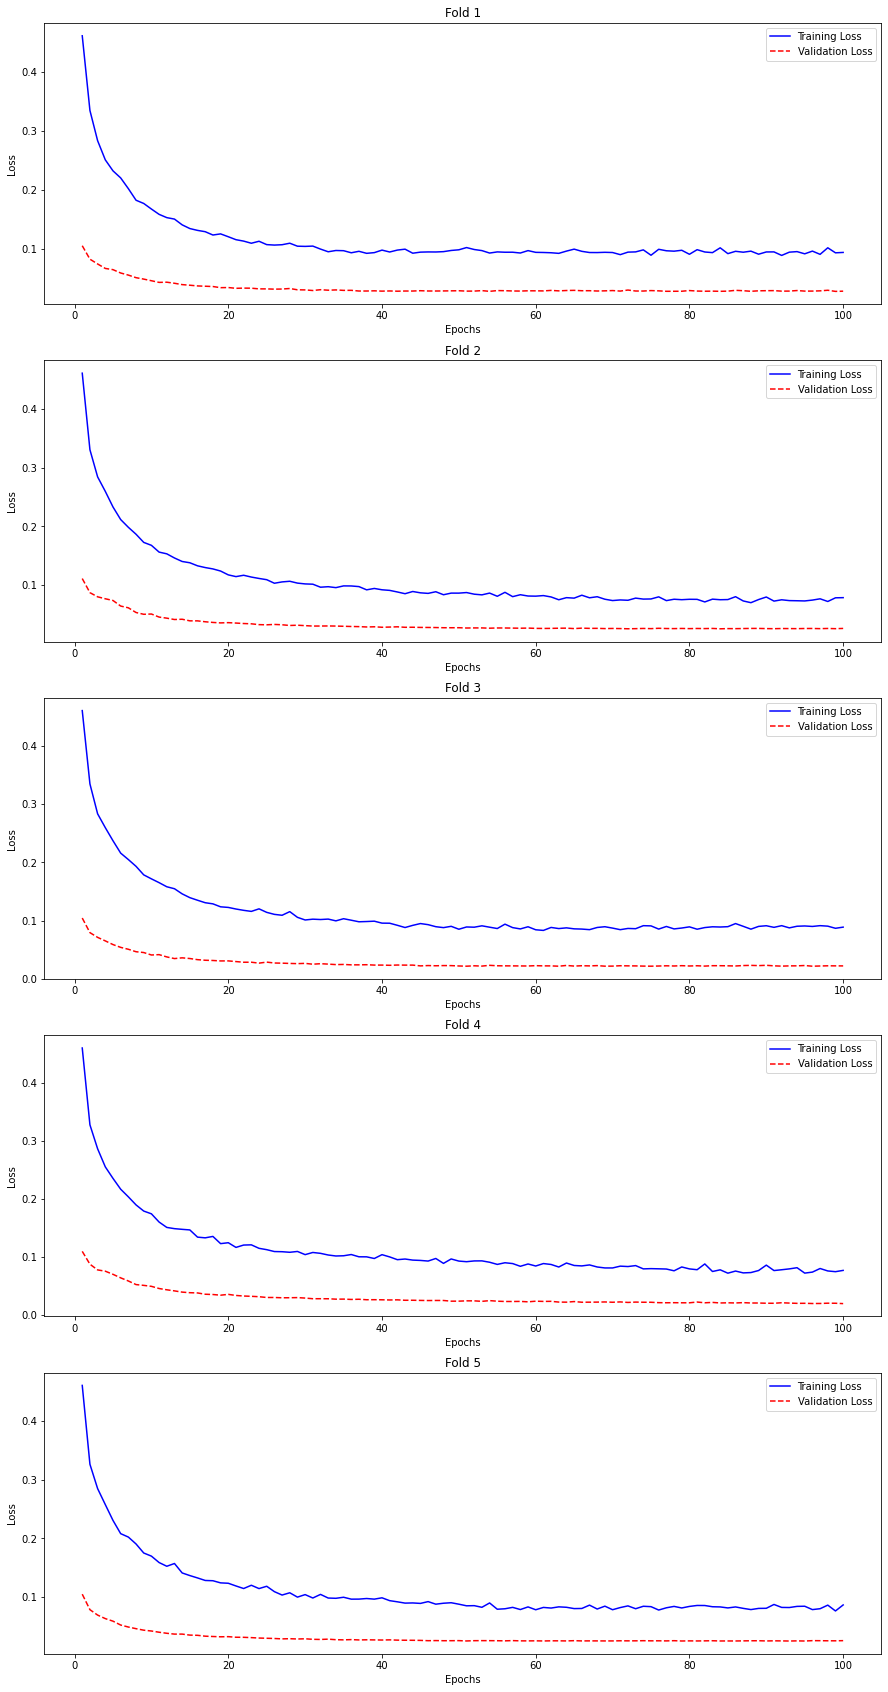

In [11]:
LP_1, Names_1, Network_1 = train_fn(X=X, y=y, n_folds=cfg.n_folds, HL_Used=cfg.HL_1)

y_pred = eval_fn(Network_1, set(Names_1), ts_data, ts_data_setup.__len__())

print("Configuration 1 Accuracy : {:.4f} %".format(accuracy_score(y, y_pred) * 100))
breaker()

LPV = []
LPT = []
for i in range(len(LP_1)):
  LPT.append(LP_1[i]["train"])
  LPV.append(LP_1[i]["valid"])

xAxis = [i+1 for i in range(cfg.epochs)]
plt.figure(figsize=(15, 30))
for fold in range(cfg.n_folds):
    plt.subplot(cfg.n_folds, 1, fold+1)
    plt.plot(xAxis, LPT[fold*cfg.epochs:(fold+1)*cfg.epochs], "b", label="Training Loss")
    plt.plot(xAxis, LPV[fold*cfg.epochs:(fold+1)*cfg.epochs], "r--", label="Validation Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Fold {fold}".format(fold=fold+1))
plt.show()

# Configuration 2


------------------------------

Training ...

------------------------------

Processing Fold 1 ...
Epoch    38: reducing learning rate of group 0 to 1.0000e-04.
Epoch    45: reducing learning rate of group 0 to 1.0000e-05.
Epoch    49: reducing learning rate of group 0 to 1.0000e-06.
Processing Fold 2 ...
Epoch    42: reducing learning rate of group 0 to 1.0000e-04.
Epoch    51: reducing learning rate of group 0 to 1.0000e-05.
Epoch    65: reducing learning rate of group 0 to 1.0000e-06.
Processing Fold 3 ...
Epoch    48: reducing learning rate of group 0 to 1.0000e-04.
Epoch    56: reducing learning rate of group 0 to 1.0000e-05.
Epoch    60: reducing learning rate of group 0 to 1.0000e-06.
Processing Fold 4 ...
Epoch    46: reducing learning rate of group 0 to 1.0000e-04.
Epoch    50: reducing learning rate of group 0 to 1.0000e-05.
Epoch    54: reducing learning rate of group 0 to 1.0000e-06.
Processing Fold 5 ...
Epoch    34: reducing learning rate of group 0 to 1.0000e-04.
Epoch

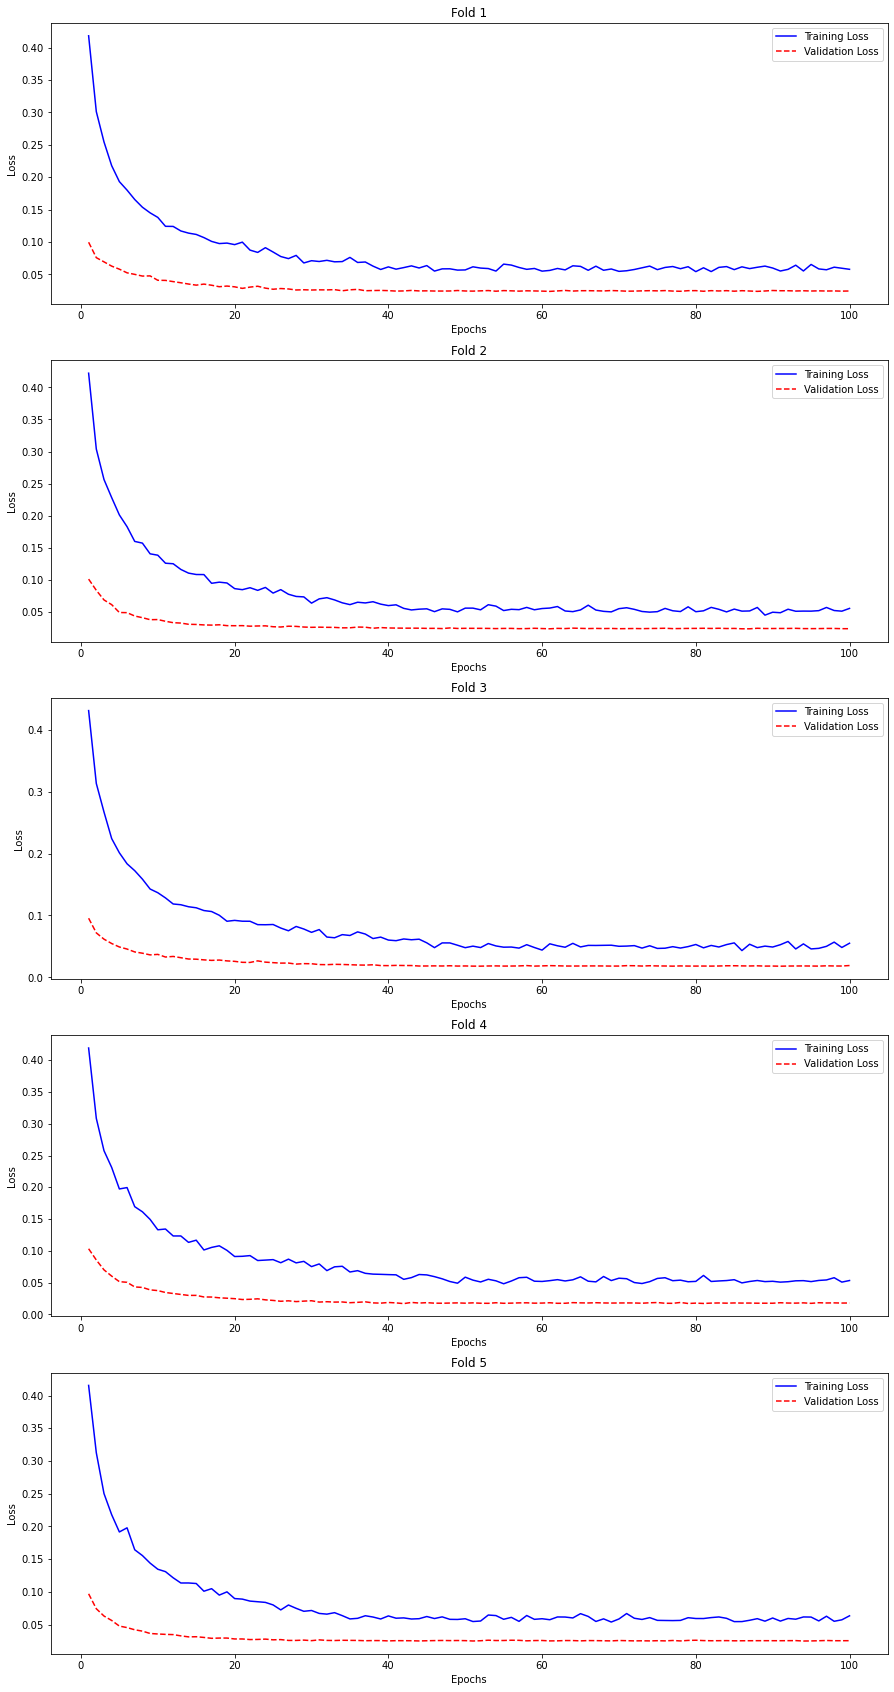

In [12]:
LP_2, Names_2, Network_2 = train_fn(X=X, y=y, n_folds=cfg.n_folds, HL_Used=cfg.HL_2)

y_pred = eval_fn(Network_2, set(Names_2), ts_data, ts_data_setup.__len__())

print("Configuration 2 Accuracy : {:.4f} %".format(accuracy_score(y, y_pred) * 100))
breaker()

LPV = []
LPT = []
for i in range(len(LP_2)):
  LPT.append(LP_2[i]["train"])
  LPV.append(LP_2[i]["valid"])

xAxis = [i+1 for i in range(cfg.epochs)]
plt.figure(figsize=(15, 30))
for fold in range(cfg.n_folds):
    plt.subplot(cfg.n_folds, 1, fold+1)
    plt.plot(xAxis, LPT[fold*cfg.epochs:(fold+1)*cfg.epochs], "b", label="Training Loss")
    plt.plot(xAxis, LPV[fold*cfg.epochs:(fold+1)*cfg.epochs], "r--", label="Validation Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Fold {fold}".format(fold=fold+1))
plt.show()

# Configuration 3


------------------------------

Training ...

------------------------------

Processing Fold 1 ...
Epoch    26: reducing learning rate of group 0 to 1.0000e-04.
Epoch    30: reducing learning rate of group 0 to 1.0000e-05.
Epoch    39: reducing learning rate of group 0 to 1.0000e-06.
Processing Fold 2 ...
Epoch    25: reducing learning rate of group 0 to 1.0000e-04.
Epoch    31: reducing learning rate of group 0 to 1.0000e-05.
Epoch    39: reducing learning rate of group 0 to 1.0000e-06.
Processing Fold 3 ...
Epoch    23: reducing learning rate of group 0 to 1.0000e-04.
Epoch    32: reducing learning rate of group 0 to 1.0000e-05.
Epoch    36: reducing learning rate of group 0 to 1.0000e-06.
Processing Fold 4 ...
Epoch    31: reducing learning rate of group 0 to 1.0000e-04.
Epoch    35: reducing learning rate of group 0 to 1.0000e-05.
Epoch    39: reducing learning rate of group 0 to 1.0000e-06.
Processing Fold 5 ...
Epoch    33: reducing learning rate of group 0 to 1.0000e-04.
Epoch

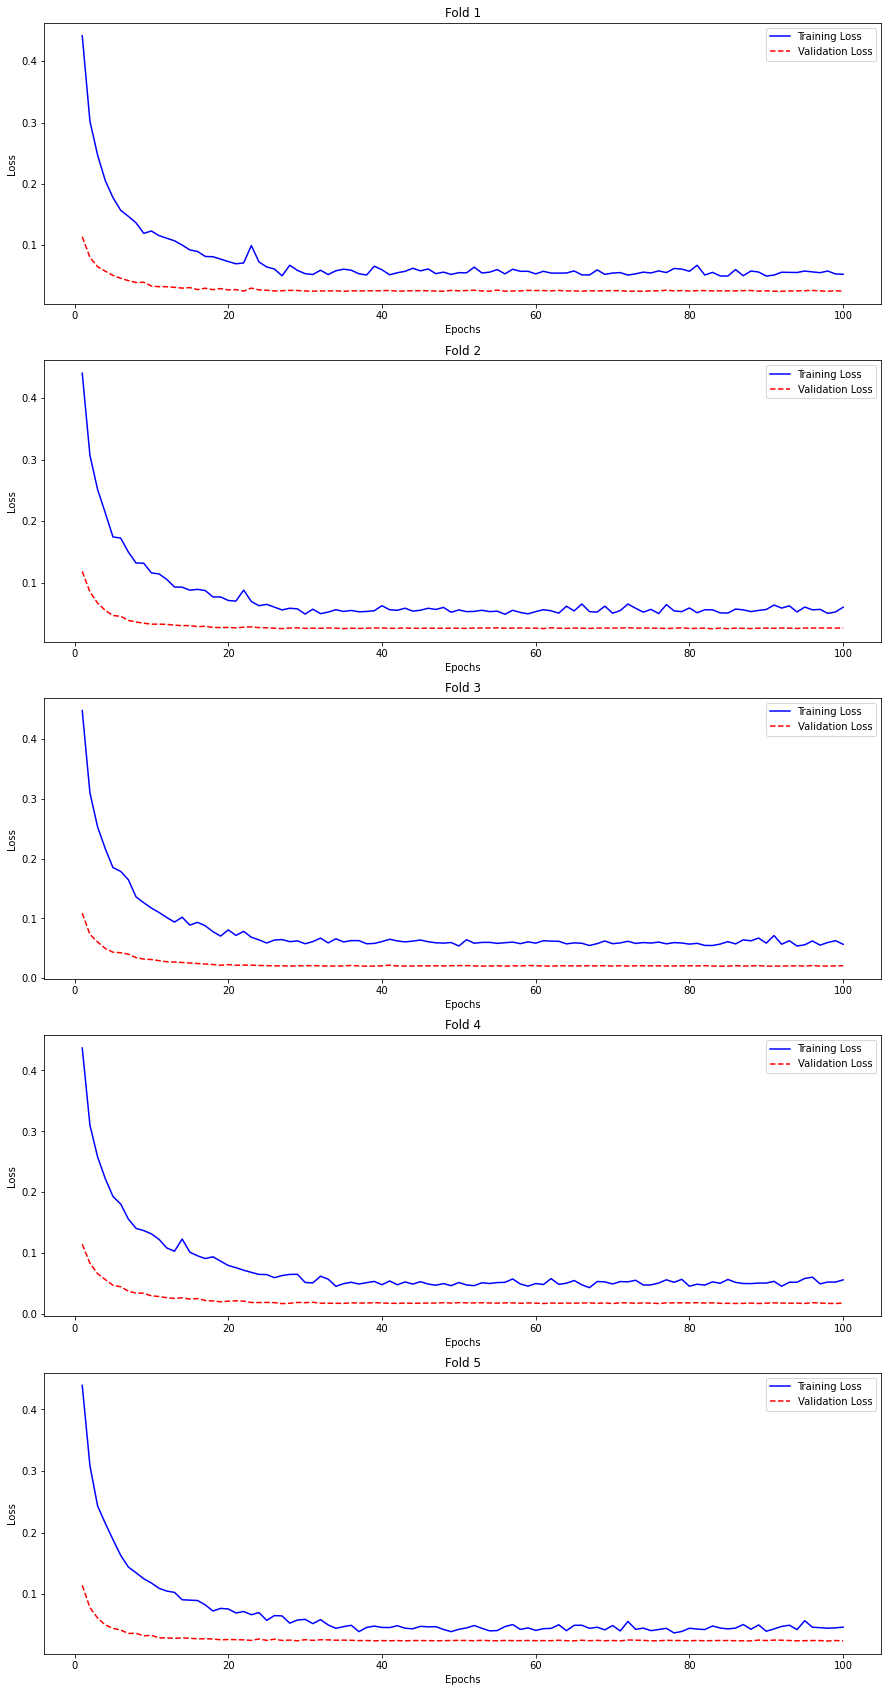

In [13]:
LP_3, Names_3, Network_3 = train_fn(X=X, y=y, n_folds=cfg.n_folds, HL_Used=cfg.HL_3)

y_pred = eval_fn(Network_3, set(Names_3), ts_data, ts_data_setup.__len__())

print("Configuration 3 Accuracy : {:.4f} %".format(accuracy_score(y, y_pred) * 100))
breaker()

LPV = []
LPT = []
for i in range(len(LP_3)):
  LPT.append(LP_3[i]["train"])
  LPV.append(LP_3[i]["valid"])

xAxis = [i+1 for i in range(cfg.epochs)]
plt.figure(figsize=(15, 30))
for fold in range(cfg.n_folds):
    plt.subplot(cfg.n_folds, 1, fold+1)
    plt.plot(xAxis, LPT[fold*cfg.epochs:(fold+1)*cfg.epochs], "b", label="Training Loss")
    plt.plot(xAxis, LPV[fold*cfg.epochs:(fold+1)*cfg.epochs], "r--", label="Validation Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Fold {fold}".format(fold=fold+1))
plt.show()

# Final Cell

In [14]:
breaker()
print("NoteBook Runtime : {:.2f}".format((time() - nb_start_time)/60))
breaker()


------------------------------

NoteBook Runtime : 5.05

------------------------------

